--- Training Network with Adam Optimizer ---
Cost after iteration 0: 2.322153
Cost after iteration 100: 0.451495
Cost after iteration 200: 0.355158
Cost after iteration 300: 0.321150
Cost after iteration 400: 0.297135
Cost after iteration 500: 0.280067
Cost after iteration 600: 0.268067
Cost after iteration 700: 0.253158
Cost after iteration 800: 0.240497
Cost after iteration 900: 0.252956
Cost after iteration 1000: 0.231714
Cost after iteration 1100: 0.230575

--- Evaluating on Test Set ---
Accuracy: 0.8631


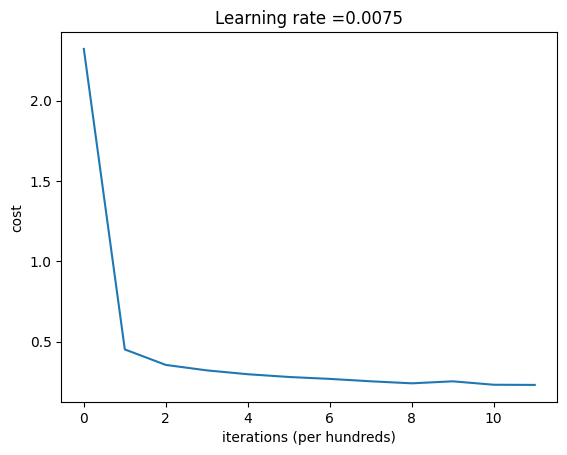

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tensorflow.keras.datasets import fashion_mnist

FASHION_MNIST_LABELS = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

(train_x_orig, train_y_orig), (test_x_orig, test_y_orig) = fashion_mnist.load_data()

train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
train_x = train_x_flatten / 255.
test_x = test_x_flatten / 255.

def one_hot_encoder(Y, C):
  Y_squeezed = np.squeeze(Y)
  Y_encoded = np.eye(C)[Y_squeezed.reshape(-1)].T
  return Y_encoded

train_y = one_hot_encoder(train_y_orig, 10)
test_y = one_hot_encoder(test_y_orig, 10)


def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def softmax(Z):
    t = np.exp(Z - np.max(Z, axis=0))
    A = t / np.sum(t, axis=0, keepdims=True)
    cache = Z
    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2./layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
    return parameters

def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    cache = (linear_cache, activation_cache)
    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)
    return AL, caches

def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1./m) * np.sum(Y * np.log(AL + 1e-8))
    cost = np.squeeze(cost)
    return cost

def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1./m) * np.dot(dZ, A_prev.T)
    db = (1./m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    dZL = AL - Y

    current_cache = caches[L-1]
    linear_cache_L, _ = current_cache
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_backward(dZL, linear_cache_L)

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_input = grads["dA" + str(l+1)]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_input, current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

# Adam optimizer

def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters['W' + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters['b' + str(l)].shape)
    return v, s

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate=0.01,
                                beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2

    for l in range(1, L + 1):
        # Momentum
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]
        v_corrected_dW = v["dW" + str(l)] / (1 - np.power(beta1, t))
        v_corrected_db = v["db" + str(l)] / (1 - np.power(beta1, t))

        # RMSprop
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.power(grads['dW' + str(l)], 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.power(grads['db' + str(l)], 2)
        s_corrected_dW = s["dW" + str(l)] / (1 - np.power(beta2, t))
        s_corrected_db = s["db" + str(l)] / (1 - np.power(beta2, t))

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected_dW / (np.sqrt(s_corrected_dW) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected_db / (np.sqrt(s_corrected_db) + epsilon)

    return parameters, v, s


# Actual model

def L_layer_model(X, Y, layers_dims, learning_rate=0.0075, num_iterations=2500, print_cost=False):
    np.random.seed(1)
    costs = []

    parameters = initialize_parameters_deep(layers_dims)
    # Initialize Adam variables
    v, s = initialize_adam(parameters)
    t = 0 # Adam counter

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        AL, caches = L_model_forward(X, parameters)

        cost = compute_cost(AL, Y)

        grads = L_model_backward(AL, Y, caches)

        # Update parameters with Adam
        t = t + 1
        parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)

        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)

    return parameters, costs


def predict(X, y, parameters):
    m = X.shape[1]
    probas, caches = L_model_forward(X, parameters)
    predictions = np.argmax(probas, axis=0)
    true_labels = np.argmax(y, axis=0)
    accuracy = np.mean(predictions == true_labels)
    print(f"Accuracy: {accuracy}")
    return predictions, accuracy


layers_dims = [train_x.shape[0], 25, 12, 10]

# Train the model with the new Adam optimizer
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations=1200, print_cost=True)

print("\nEvaluating on Test Set")
pred_test, accuracy_test = predict(test_x, test_y, parameters)

plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(0.0075))
plt.show()
